<h1>Network SIR Hybrid Model</h1>

In [ ]:
import numpy as np
from epidemic_models.HYBRID import *

$${ \frac{dS_i}{dt} = -\frac{S_i}{N} \sum_{j} \beta_{ij} I_j \\ \frac{dI_i}{dt} = \frac{S_i}{N} \sum_{j} \beta_{ij} I_j  - \gamma_i I \\ \frac{dR}{dt} = \gamma_i I}$$
with loss function
$$L = \left(-\frac{S_i}{N} \sum_{j} \beta_{ij} I_j + \frac{\hat{S}_i}{N} \sum_{j} \beta_{ij} \hat{I}_j\right)^2 + \left(\frac{S_i}{N} \sum_{j} \beta_{ij} I_j - \gamma_i I - \frac{\hat{S}_i}{N} \sum_{j} \beta_{ij}  \hat{I}_j + \gamma_i \hat{I}\right)^2 + \left(\gamma_i I - \gamma_i \hat{I}\right)^2$$

In [201]:
sir, loss, weights = run_simulation(200,trials=15,learning_rate=10**-12)

Text(0.5, 0, 'Iteration')

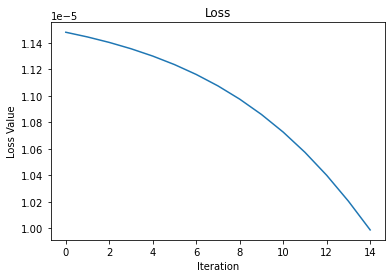

In [202]:
plt.plot(np.arange(len(loss)),loss)
plt.title('Loss')
plt.ylabel('Loss Value')
plt.xlabel('Iteration')

Text(0.5, 0, 'Days')

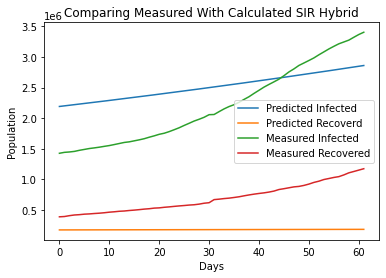

In [203]:
start_date = '2020-05-01'
end_date = '2020-07-01'

url = 'https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States_by_population'
file = urllib.request.urlopen(url).read()
tables = str(file).split('<table')
for table in tables:
    if '39,368,078' in table:
        pop_table = '<table'+table.split('table>')[0]+'table>'
        pop_table = pop_table.replace('\\n','')
        df = pd.read_html(pop_table)[0]
df.columns = df.columns.get_level_values(1)

df = df[df['State or territory'] !='Puerto Rico']
df = df[df['State or territory'] !='Guam']
df = df[df['State or territory'] !='U.S. Virgin Islands']
df = df[df['State or territory'] !='Northern Mariana Islands']
df = df[df['State or territory'] !='American Samoa']
df = df[df['State or territory'] !='Contiguous United States']
df = df[df['State or territory'] !='The fifty states and D.C.']
df = df[df['State or territory'] !='Total United States']
df = df[df['State or territory'] !='The fifty states']

start_time = datetime.datetime.strptime(start_date,'%Y-%m-%d')
end_time = datetime.datetime.strptime(end_date,'%Y-%m-%d')
cycles = int((end_time-start_time).total_seconds()/200)

states = df['State or territory'].to_numpy()

states_data = {}
for state in states:
    states_data[state] = pd.read_csv('Data/State_Data/'\
        +state.lower().replace(' ','-')+'-history.csv').fillna(0)


dates = states_data['Arizona'].date[217:279].to_numpy()
sir_data = np.zeros((len(dates),2))
#sir_data[0,0] = np.sum(df['EstimatedJuly 1, 2020[6]'].to_numpy(dtype=float)) 

for d in range(len(dates)):
    date = dates[d]
    for n in range(len(states)):
        state_data = states_data[states[n]]
        positive = state_data[state_data['date']==date].positive.to_numpy(dtype=float)[0]
        recovered = state_data[state_data['date']==date].recovered.to_numpy(dtype=float)[0]
        sir_data[len(dates)-1-d,0] += positive - recovered
        sir_data[len(dates)-1-d,1] += recovered
        
time = np.arange(0,len(sir[:,0])*200,200)/24/3600
#plt.plot(time,sir[:,0])
plt.plot(time,sir[:,1],label="Predicted Infected")
plt.plot(time,sir[:,2],label="Predicted Recoverd")
plt.plot(np.arange(len(dates)),sir_data[:,0],label="Measured Infected")
plt.plot(np.arange(len(dates)),sir_data[:,1],label="Measured Recovered")
plt.legend()
plt.title('Comparing Measured With Calculated SIR Hybrid')
plt.ylabel('Population')
plt.xlabel('Days')

Text(0.5, 1.0, 'Correlated Populations')

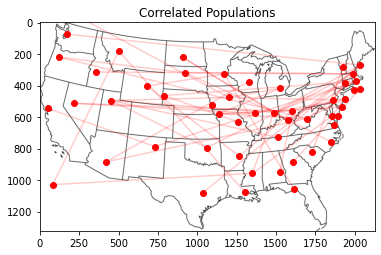

In [222]:
trials = 10
beta = np.zeros_like(weights['beta'])
for trial in tqdm(range(10)):
    sir, loss, weights = run_simulation(200,trials=15,learning_rate=10**-12)
    beta += weights['beta']/10
    
def r(l):
    lon, lat = l
    y = 3.53545999e-01*lat**2 - 1.09993007e-01*lon**2\
    -1.17889646e-01*lat*lon - 6.88413422e+01*lat\
    +2.53770516e+01*lon + 1.74488695e+03
    x =-6.23421581e-01*lat**2 +  1.71644223e-02*lon**2+\
    +6.43396983e-01*lat*lon - 1.65264449e+01*lat + \
    -6.70263977e+01*lon + 6.55819583e+03 
    return np.array([x,y])

lonlat=np.array([[123, 97, 84, 73, 76, 89, 83, 84, 78, 84,\
                 74, 77, 122, 112, 71, 86, 86, 92, 76, 89,\
                 107, 93, 81, 86, 91, 84, 123, 97, 72, 111,\
                 93, 119, 92, 90, 95, 105, 96, 116, 81, 121,\
                 71, 69, 112, 71, 75, 100, 100, 122, 77, 72,\
                 104],\
                 [38, 30, 30, 42, 40, 39, 39, 33, 35, 42,\
                 40, 37, 47, 33, 42, 36, 39, 38, 38, 43,\
                 42, 44, 34, 32, 30, 38, 44, 35, 41, 40,\
                 41, 39, 34, 32, 39, 35, 40, 43, 38, 35,\
                 43, 44, 46, 41, 39, 44, 46, 50, 38, 44,\
                 41]])

locations = r(lonlat)
locations[1,-12]+=300
locations[0,-22]-=75
img=plt.imread('usa.jpg')
b_cutoff = np.max(beta)*0.8
for i in range(len(states)):
    for j in range(len(states)):
        if beta[i,j]>b_cutoff:
            x1=locations[0,i]
            y1=locations[1,i]
            x2=locations[0,j]
            y2=locations[1][j]
            points = np.array([[x1,x2],[y1,y2]])
            plt.plot(points[0],points[1],color='r', alpha=0.2)
        
plt.scatter(locations[0],locations[1], color='r')
plt.imshow(img, cmap="gray")
plt.title('Correlated Populations')